In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

This notebook aims to show a simple example with an autoencoder. The highlights of this notebook are that

* we can customize problem difficulty (because we control the input)
* we can customize the model expressiveness to capture problem difficulty (well, it's a todo)

I will spend some time manually tuning these to make it a realistic problem. After this is done, we have 400 parameter combinations, each with 2 contininous variables to tune. The variables we have to tune are

* model
    * initialization
    * activation function
    * weight decay (which is similar to $\ell_2$ regularization)
* optimizer
    * which optimizer to use (e.g., Adam, SGD)
    * batch size used to approximate gradient
    * learning rate (but not for Adam)
    * momentum for SGD

I believe this is an interesting problem. For example, switching activation from ReLU to PReLU caused the loss after 1st epoch to go from ~0.20 to 0.12.

## Setup

In [2]:
import torch
torch.__version__

'0.4.1'

In [3]:
import numpy as np
import noisy_mnist

Using TensorFlow backend.
/home/ssievert/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Input data
`autoencoder` is a package I wrote to noise MNIST images. It outputs a NumPy ndarray of noisy images.

In [8]:
import noisy_mnist
noisy, clean = noisy_mnist.dataset()#n=1024)
assert isinstance(noisy, np.ndarray)

from sklearn.model_selection import train_test_split
noisy_train, noisy_test, clean_train, clean_test = train_test_split(noisy, clean)

In [9]:
noisy_train.shape

(52500, 1, 28, 28)

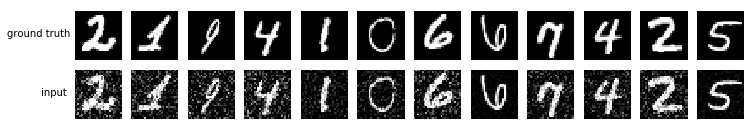

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

w = 1.0
ncols = 12
idx = np.random.choice(len(clean_test), size=ncols)
fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(ncols*w, 2*w))
for col, (lower, upper, i) in enumerate(zip(axs[1], axs[0], idx)):
    if col == 0:
        upper.text(-40, 15, 'ground truth')
        lower.text(-20, 15, 'input')
    clean = clean_train[i].reshape(28, 28)
    noisy = noisy_train[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray'}
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(noisy, ax=lower, **kwargs)
plt.show()

This input has random amounts of noise – it ranges everywhere from perfectly clean images to moderately corrupted images.

## Model creation

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
import skorch

This convolutional model is adaptived from https://github.com/Kaixhin/Autoencoders/blob/master/models/ConvAE.lua, which is turn adapted from https://blog.keras.io/building-autoencoders-in-keras.html.

I have allowed custimization of

* the activation function
* the initialization scheme
* **TODO** width/depth to allow more complex models (which is suited for random noise)

**Notes on other models**
* https://github.com/baldassarreFe/zalando-pytorch/blob/master/notebooks/4.0-fb-autoencoder.ipynb
* Maybe go with VGG deconv net at https://github.com/csgwon/pytorch-deconvnet/blob/master/models/vgg16_deconv.py (will require ImageNet)
* A simple DAE is at https://github.com/ReyhaneAskari/pytorch_experiments/blob/master/DAE.py

In [13]:
import torch.nn as nn
from toolz import partial
      
def _initialize(method, layer, gain=1):
    weight = layer.weight.data
    _before = weight.data.clone()
    kwargs = {'gain': gain} if 'xavier' in str(method) else {}
    method(weight.data, **kwargs)
    assert torch.all(weight.data != _before)
    
class Autoencoder(nn.Module):
    """ Autoencoder adapted from [1]
    
    [1]:https://github.com/Kaixhin/Autoencoders/blob/master/models/ConvAE.lua
    """
    def __init__(self, activation='ReLU', init='xavier_uniform_', width_factor=1):
        super().__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.activation = activation
        self.init = init
        
        init_method = getattr(torch.nn.init, init)
        act_layer = getattr(nn, activation)
        print(act_layer)
       
        gain = 1
        if self.activation in ['LeakyReLU', 'ReLU']:
            name = 'leaky_relu' if self.activation == 'LeakyReLU' else 'relu'
            gain = torch.nn.init.calculate_gain(name)
        if self.activation != 'PReLU':
            act_layer = partial(act_layer, inplace=True)
        
        width = int(width_factor * 32)
        layers = [nn.Conv2d(1, width, kernel_size=3, padding=1, stride=1),
                  act_layer(),
                  nn.MaxPool2d(2, stride=2, padding=1),
                  nn.Conv2d(width, width, kernel_size=3, padding=1, stride=1),
                  act_layer(),
                  nn.MaxPool2d(2, stride=2, padding=0)]
        for layer in layers:
            if hasattr(layer, 'weight') and layer.weight.data.dim() > 1:
                _initialize(init_method, layer)
            
        self.encoder = nn.Sequential(*layers).to(device)
        
        modules = []
        modules += [[nn.Conv2d(width, width, kernel_size=3, stride=1, padding=1),
                    act_layer()]]
        modules += [[nn.Conv2d(width, width, kernel_size=3, stride=1, padding=1),
                    act_layer()]]
        modules += [[nn.Conv2d(width, 1, kernel_size=3, stride=1, padding=1),
                    nn.Sigmoid()]]
        self.decoders = []
        for module in modules:
            [_initialize(init_method, layer) for layer in module
             if hasattr(layer, 'weight') and layer.weight.data.dim() > 1]
            self.decoders += [nn.Sequential(*module).to(device)]
        
    def forward(self, x):
        x = self.encoder(x)
                  
        for i, decoder in enumerate(self.decoders):
            x = decoder(x)
            if i < len(self.decoders) - 1:
                x = F.interpolate(x, scale_factor=2)
        return x

## Hyperparameters

In [14]:
from pprint import pprint
class Trim(skorch.NeuralNetRegressor):
    """
    This wrapper trims the arguments in `params` to make 
    sure they're accepted by the optimizer
    """
    def __init__(self, verbose=True, **kwargs):
        if kwargs['optimizer'] != 'Adam':
            kwargs.pop('optimizer__amsgrad', None)
        if kwargs['optimizer'] == 'Adam':
            kwargs.pop('optimizer__lr', None)
        if kwargs['optimizer'] != 'SGD':
            kwargs.pop('optimizer__nesterov')
            kwargs.pop('optimizer__momentum')
        kwargs['optimizer'] = getattr(torch.optim, kwargs['optimizer'])
        pprint({k: v for k, v in kwargs.items() if k != 'module'})
        super().__init__(**kwargs)

params = {
    'module__init': ['xavier_uniform_',
                     'xavier_normal_',
                     'kaiming_uniform_',
                     'kaiming_normal_',
                    ],
    'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'],
    'optimizer': ['SGD',
                  'ASGD',
                  'Adam',
                  'Adagrad',
                  'RMSprop'],  # optimizers in Adam's paper + ASGD
    'batch_size': [32, 64, 128, 256, 512],
    'optimizer__lr': np.logspace(2, -2, num=1000),  # all optimizers but Adam
    'optimizer__weight_decay': [0] + np.logspace(-8, -3, num=1000).tolist(),  # all optimizers
    'optimizer__nesterov': [True],  # only for SGD
    'optimizer__momentum': np.logspace(-4, 0, num=1000),  # only for SGD
}

## Fitting

In [15]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

device = 'cpu'
model = Autoencoder()
if torch.cuda.is_available():
    device = 'cuda'
    model = model.to('cuda')
    
net = Trim(
    module=model,
    module__init='xavier_uniform_',
    module__activation='PReLU',
    max_epochs=20,
    optimizer='Adam',
    optimizer__lr=1.0,
    optimizer__weight_decay=1e-5,
    optimizer__nesterov=True,
    optimizer__momentum=1e-2,
    batch_size=64,
    # train_split=None,  # if only use training data; we will eventually
    #criterion=torch.nn.MSELoss,
    criterion=torch.nn.BCELoss,
    device='cuda',
    warm_start=True,
)

<class 'torch.nn.modules.activation.ReLU'>
{'batch_size': 64,
 'criterion': <class 'torch.nn.modules.loss.BCELoss'>,
 'device': 'cuda',
 'max_epochs': 20,
 'module__activation': 'PReLU',
 'module__init': 'xavier_uniform_',
 'optimizer': <class 'torch.optim.adam.Adam'>,
 'optimizer__weight_decay': 1e-05,
 'warm_start': True}


In [16]:
net.fit(noisy_train, clean_train)

Re-initializing module!
<class 'torch.nn.modules.activation.PReLU'>
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1290        0.1144  4.5228
      2        0.1053        0.1074  4.5657
      3        0.1034        0.1032  4.5263
      4        0.1021        0.1018  4.4973
      5        0.1014        0.1009  4.5685
      6        0.1006        0.1000  4.5073
      7        0.1002        0.1037  4.5860
      8        0.0998        0.1045  4.5521
      9        0.0994        0.0999  4.5896
     10        0.0991        0.1010  4.5799
     11        0.0989        0.0996  4.5751
     12        0.0986        0.1014  4.5972
     13        0.0984        0.0990  4.4776
     14        0.0982        0.0987  4.6029
     15        0.0981        0.0983  4.6004
     16        0.0980        0.0982  4.5679
     17        0.0979        0.0982  4.5686
     18        0.0979        0.0979  4.5877
     19        0.0978        0.0976  4.5966
     20 

<class '__main__.Trim'>[initialized](
  module_=Autoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  ),
)

## Output

In [17]:
clean_test_hat = net.forward(noisy_test)

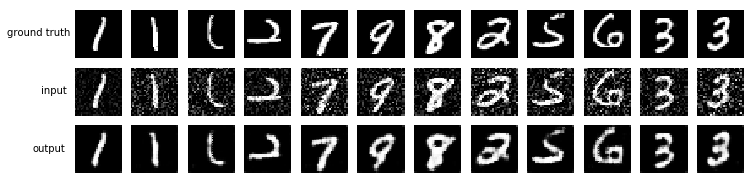

In [18]:
w = 1.0
ncols = 12
# idx = np.random.choice(len(clean_test), size=ncols)

fig, axs = plt.subplots(nrows=3, ncols=ncols, figsize=(ncols*w, 3*w))
for col, (lower, middle, upper, i) in enumerate(zip(axs[2], axs[1], axs[0], idx)):
    if col == 0:
        upper.text(-40, 15, 'ground truth')
        middle.text(-20, 15, 'input')
        lower.text(-25, 15, 'output')

    i = np.random.randint(len(clean_test))
    clean = clean_test[i].reshape(28, 28)
    predicted = clean_test_hat[i].reshape(28, 28)
    noisy = noisy_test[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray'}
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(noisy, ax=middle, **kwargs)
    sns.heatmap(predicted, ax=lower, **kwargs)
plt.show()